AttributeError: PathCollection.set() got an unexpected keyword argument 'z'

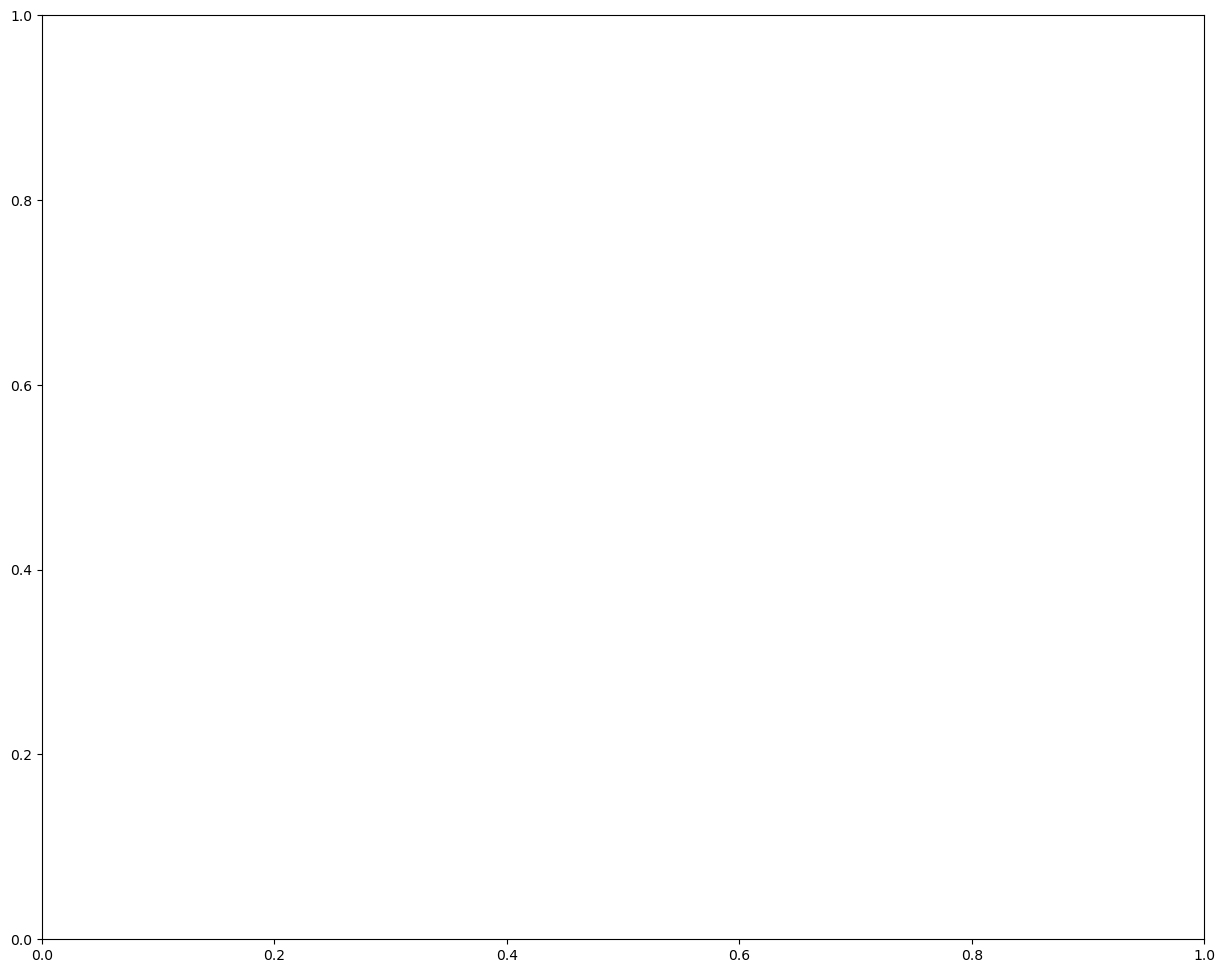

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import os
import json
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------------------------------------------------------------------------------------
# Load the dataset

path = "/Volumes/dax-hd/project-data/search-files/merged-data.csv"
base_save_folder = "/Volumes/dax-hd/project-data/images/tsne_topology_"
cath_dict_path = "/Volumes/dax-hd/project-data/search-files/cath-archetype-dict.txt"

df = pd.read_csv(path)

with open(cath_dict_path, 'r') as file:
    cath_dict = json.load(file)

# ---------------------------------------------------------------------------------------------------
# Add the architecture name to df

def add_topology_description(df, cath_dict):
    def get_topology_description(row):
        class_num = str(row['Class number'])
        arch_num = str(row['Architecture number'])
        top_num = str(row['Topology number'])
        try:
            description = cath_dict[class_num][arch_num][top_num]['description']
            return description
        except KeyError:
            return "Unknown"
    
    df['topology_description'] = df.apply(get_topology_description, axis=1)
    return df

df = add_topology_description(df, cath_dict)

# ---------------------------------------------------------------------------------------------------

def filter_for_archetypes(df, cath_dict):
    archetype_ids = []
    for _, row in df.iterrows():
        class_num = str(row['Class number'])
        arch_num = str(row['Architecture number'])
        top_num = str(row['Topology number'])
        try:
            protein_id = cath_dict[class_num][arch_num][top_num]['protein_id']
            if protein_id[:4] in row['design_name']:
                archetype_ids.append(row['design_name'])
        except KeyError:
            continue
    return df[df['design_name'].isin(archetype_ids)]

# ---------------------------------------------------------------------------------------------------

selected_architectures = ["alpha_beta_complex (3,90)"]

selected_columns = [
    
    # "composition_ALA","composition_CYS","composition_ASP","composition_GLU","composition_PHE","composition_GLY",
    # "composition_HIS","composition_ILE","composition_LYS","composition_LEU","composition_MET","composition_ASN",
    # "composition_PRO","composition_GLN","composition_ARG","composition_SER","composition_THR","composition_VAL",
    # "composition_TRP","composition_UNK","composition_TYR",
    # "ss_prop_alpha_helix","ss_prop_beta_bridge","ss_prop_beta_strand","ss_prop_3_10_helix","ss_prop_pi_helix",
    # "ss_prop_hbonded_turn","ss_prop_bend","ss_prop_loop",
    "hydrophobic_fitness",
    "isoelectric_point",
    "charge",
    "mass",
    "num_residues",
    "packing_density",
    "budeff_total",
    "evoef2_ref_total",
    "dfire2_total",
    "rosetta_total",
    "aggrescan3d_avg_value"
]

# ---------------------------------------------------------------------------------------------------

df_filtered = df #filter_for_archetypes(df, cath_dict)
df_selected_cleaned = df_filtered[selected_columns].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected_cleaned)

# ---------------------------------------------------------------------------------------------------

for architecture_name in df['architecture_name'].unique():
    if architecture_name not in selected_architectures:
        continue

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_filtered_architecture = df[df['architecture_name'] == architecture_name]
    df_selected = df_filtered_architecture[selected_columns]
    df_selected_cleaned = df_selected.dropna()
    
    if df_selected_cleaned.empty:
        continue

    # Make sure to get 'topology_description' before scaling
    topology_descriptions = df_filtered_architecture['topology_description'][df_selected_cleaned.index].reset_index(drop=True)

    save_folder = os.path.join(base_save_folder, architecture_name.replace('/', '_'))
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Scaling
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_selected_cleaned)

    # Initialize and fit TSNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(scaled_features)
    tsne_df = pd.DataFrame(data=tsne_results, columns=['Dimension 1', 'Dimension 2'])

    # Assign 'topology_description' after fitting TSNE
    tsne_df['topology_description'] = topology_descriptions.values

    # ---------------------------------------------------------------------------------------------------
    # Plotting

    unique_topologies = tsne_df['topology_description'].unique()
    palette = sns.color_palette('tab20c', n_colors=len(unique_topologies))
    topology_color_mapping = {topology: color for topology, color in zip(unique_topologies, palette)}

    plt.figure(figsize=(15, 12))
    scatter_plot = sns.scatterplot(
        x='Dimension 1', y='Dimension 2',
        hue='topology_description',
        palette=topology_color_mapping,
        data=tsne_df, s=100
    )
    plt.title(f't-SNE for {architecture_name}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Handling legend
    handles, labels = scatter_plot.get_legend_handles_labels()
    plt.legend([],[], frameon=False)
    plt.savefig(os.path.join(save_folder, 'tsne_scatter_by_topology.png'), bbox_inches='tight')
    plt.close()

    # Save legend separately
    fig_legend = plt.figure(figsize=(3, 4))
    plt.figlegend(handles, labels, loc='center')
    plt.savefig(os.path.join(save_folder, 'legend.png'), bbox_inches='tight')
    plt.close(fig_legend)

# ---------------------------------------------------------------------------------------------------




In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import os
import json
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------------------------------------------------------------------------------------
# Load the dataset

path = "/Volumes/dax-hd/project-data/search-files/merged-data.csv"
base_save_folder = "/Volumes/dax-hd/project-data/images/tsne_topology_"
cath_dict_path = "/Volumes/dax-hd/project-data/search-files/cath-archetype-dict.txt"

df = pd.read_csv(path)

with open(cath_dict_path, 'r') as file:
    cath_dict = json.load(file)

# ---------------------------------------------------------------------------------------------------
# Add the architecture name to df

def add_topology_description(df, cath_dict):
    def get_topology_description(row):
        class_num = str(row['Class number'])
        arch_num = str(row['Architecture number'])
        top_num = str(row['Topology number'])
        try:
            description = cath_dict[class_num][arch_num][top_num]['description']
            return description
        except KeyError:
            return "Unknown"
    
    df['topology_description'] = df.apply(get_topology_description, axis=1)
    return df

df = add_topology_description(df, cath_dict)

# ---------------------------------------------------------------------------------------------------

def filter_for_archetypes(df, cath_dict):
    archetype_ids = []
    for _, row in df.iterrows():
        class_num = str(row['Class number'])
        arch_num = str(row['Architecture number'])
        top_num = str(row['Topology number'])
        try:
            protein_id = cath_dict[class_num][arch_num][top_num]['protein_id']
            if protein_id[:4] in row['design_name']:
                archetype_ids.append(row['design_name'])
        except KeyError:
            continue
    return df[df['design_name'].isin(archetype_ids)]

# ---------------------------------------------------------------------------------------------------

selected_architectures = ["sandwich (2,60)"]

selected_columns = [
    
    # "composition_ALA",
    # "composition_CYS","composition_ASP",
    # "composition_GLU",
    # "composition_PHE","composition_GLY",
    # "composition_HIS","composition_ILE","composition_LYS",
    # "composition_LEU",
    # "composition_MET","composition_ASN",
    # "composition_PRO","composition_GLN",
    # "composition_ARG","composition_SER","composition_THR",
    # "composition_VAL",
    # "composition_TRP","composition_UNK","composition_TYR",
    # "ss_prop_alpha_helix","ss_prop_beta_bridge","ss_prop_beta_strand","ss_prop_3_10_helix","ss_prop_pi_helix",
    # "ss_prop_hbonded_turn","ss_prop_bend","ss_prop_loop",
    # "hydrophobic_fitness",
    # "isoelectric_point",
    # "charge",
    "mass",
    # "num_residues",
    # "packing_density",
    "budeff_total",
    # "evoef2_ref_total",
    # "dfire2_total",
    # "rosetta_total",
    "aggrescan3d_avg_value"
]

# ---------------------------------------------------------------------------------------------------

df_filtered = df #filter_for_archetypes(df, cath_dict)
df_selected_cleaned = df_filtered[selected_columns].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected_cleaned)

# ---------------------------------------------------------------------------------------------------

for architecture_name in df['architecture_name'].unique():
    if architecture_name not in selected_architectures:
        continue

    df_architecture = df[df['architecture_name'] == architecture_name]
    df_selected_cleaned = df_architecture[selected_columns].dropna()

    if df_selected_cleaned.empty:
        print(f"No data available for {architecture_name}. Skipping...")
        continue

    topology_descriptions = df_architecture['topology_description'][df_selected_cleaned.index].reset_index(drop=True)

    # Scaling
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_selected_cleaned)

    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(scaled_features)
    
    tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
    tsne_df['topology_description'] = topology_descriptions

    # 3D Plotting
    fig = plt.figure(figsize=(30, 21))
    ax = fig.add_subplot(111, projection='3d')

    codes, uniques = pd.factorize(tsne_df['topology_description'])

    num_colors = len(uniques)

    repeated_cmap = plt.cm.tab20c(np.linspace(0, 1, num_colors) % 1)

    scatter = ax.scatter(
        tsne_df['Dimension 1'], tsne_df['Dimension 2'], tsne_df['Dimension 3'],
        c=[repeated_cmap[i] for i in codes],
        s=100
    )

    legend_handles = [mpatches.Patch(color=repeated_cmap[i], label=uniques[i]) for i in range(num_colors)]

    ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Topologies")

    ax.set_title(f't-SNE 3D Visualization')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')

    figure_path = os.path.join(base_save_folder, f"tsne_3d_{architecture_name}.png")
    plt.savefig(figure_path)
    plt.close(fig)

